# Imports

In [1]:
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from pyod.utils.stat_models import pairwise_distances_no_broadcast
from keras import backend as K

import pickle
import pandas as pd
import numpy as np
import gc


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from scipy.special import erf
import matplotlib as mp

import warnings
warnings.filterwarnings('ignore')

/Users/omershafiq/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/omershafiq/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/omershafiq/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/omershafiq/anaconda3/lib/

# Data Load

In [2]:
df = pd.read_csv('/Volumes/C/Thesis-2019/cluster-output/DG_out.csv', sep=',')

df.drop('tx_hash', axis=1, inplace=True)
df.drop('in_malicious', axis=1, inplace=True)
df.drop('out_malicious', axis=1, inplace=True)
df.drop('is_malicious', axis=1, inplace=True)
df.drop('all_malicious', axis=1, inplace=True)

# Log scale to normalize the data
scaled_df = df.copy()

scaled_df['indegree'] = np.log1p(scaled_df['indegree'])
scaled_df['outdegree']= np.log1p(scaled_df['outdegree'])
scaled_df['in_btc'] = np.log1p(scaled_df['in_btc'])
scaled_df['out_btc']= np.log1p(scaled_df['out_btc'])
scaled_df['total_btc']= np.log1p(scaled_df['total_btc'])
scaled_df['mean_in_btc']= np.log1p(scaled_df['mean_in_btc'])
scaled_df['mean_out_btc']= np.log1p(scaled_df['mean_out_btc'])

# RobustScaler is less prone to outliers.
from sklearn.preprocessing import RobustScaler
rob_scaler = RobustScaler()

scaled_df['indegree'] = rob_scaler.fit_transform(scaled_df['indegree'].values.reshape(-1,1))
scaled_df['outdegree'] = rob_scaler.fit_transform(scaled_df['outdegree'].values.reshape(-1,1))
scaled_df['in_btc'] = rob_scaler.fit_transform(scaled_df['in_btc'].values.reshape(-1,1))
scaled_df['out_btc'] = rob_scaler.fit_transform(scaled_df['out_btc'].values.reshape(-1,1))
scaled_df['total_btc'] = rob_scaler.fit_transform(scaled_df['total_btc'].values.reshape(-1,1))
scaled_df['mean_in_btc'] = rob_scaler.fit_transform(scaled_df['mean_in_btc'].values.reshape(-1,1))
scaled_df['mean_out_btc'] = rob_scaler.fit_transform(scaled_df['mean_out_btc'].values.reshape(-1,1))

del df #free memory
gc.collect()

original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(scaled_df.iloc[:,:-1], scaled_df['out_and_tx_malicious'], test_size = 0.20, random_state=10)

del scaled_df #free memory
gc.collect()

17

In [3]:
pd.value_counts(original_ytest)

0    6049601
1         26
Name: out_and_tx_malicious, dtype: int64

# Load Models

In [4]:
#F1 Score metric to load keras model
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Convert autoencoder probablities to actual predictions
class Autoencoder:
    def __init__(self, trainingData, model, threshold, classes = 2):
        self.model = model
        self.threshold = threshold
        self.X_norm = trainingData
        self._classes = classes
        self.decision_scores_ = np.empty(0)
        self._mu = None
        self._sigma = None
        self.pred_Xscores = None
    
    def mse(self, X, pred_scores):
        return np.mean(np.power(X - pred_scores, 2), axis=1)

    def predict(self, X):
        pred_scores = self.model.predict(X)
        error = self.mse(X, pred_scores)
        error_df = pd.DataFrame({'reconstruction_error': error})
        prediction = [1 if e > self.threshold else 0 for e in error_df.reconstruction_error.values]
        return prediction
    
    def decision_function(self, X):
        pred_scores = self.model.predict(X)
        return np.array(self.mse(X, pred_scores))

    def predict_proba(self, X, method='linear'):
            if len(self.decision_scores_) == 0:
                self.pred_Xscores = self.model.predict(self.X_norm)
                self.decision_scores_ = pairwise_distances_no_broadcast(self.X_norm, self.pred_Xscores)
                self._mu = np.mean(self.decision_scores_)
                self._sigma = np.std(self.decision_scores_)
        
            train_scores = self.decision_scores_

            test_scores = self.decision_function(X)

            probs = np.zeros([X.shape[0], int(self._classes)])
            if method == 'linear':
                scaler = MinMaxScaler().fit(train_scores.reshape(-1, 1))
                probs[:, 1] = scaler.transform(
                    test_scores.reshape(-1, 1)).ravel().clip(0, 1)
                probs[:, 0] = 1 - probs[:, 1]
                return probs

            elif method == 'unify':
                # turn output into probability
                pre_erf_score = (test_scores - self._mu) / (
                        self._sigma * np.sqrt(2))
                erf_score = erf(pre_erf_score)
                probs[:, 1] = erf_score.clip(0, 1).ravel()
                probs[:, 0] = 1 - probs[:, 1]
                return probs
            else:
                raise ValueError(method,
                                 'is not a valid probability conversion method')
        
        
#Merge clusters for Kmeans
class Kmeans:
    def __init__(self, k, model, merge_clusters):
        self.model = model
        self.merge_clusters = merge_clusters
        self.k = k
        
    def predict(self, X):
        prediction = self.model.predict(X)
        for i in range(0,self.k):
            if (i+1) in self.merge_clusters:
                prediction[prediction == i] = -1
            else:
                prediction[prediction == i] = 0

        prediction[prediction == -1] = 1
        return prediction
    
    def mse(self, X, pred_scores):
        return np.mean(np.power(X - pred_scores, 2), axis=1)
    
    def decision_function(self, X): #Not Supported
        return np.zeros(len(X)) 
    
    def predict_proba(self, X): #Not supported
        return np.zeros((len(X),2)) 

In [5]:
path = '/Users/omershafiq/Dropbox/Thesis/Analysis-Code/Analysis-2019/Notebooks/Final/Unsupervised/Models'

iforest = pickle.load(open(path+'/IForest/i=16.h5', 'rb'))
hbos = pickle.load(open(path+'/HBOS/i=17.h5', 'rb'))
cblof = pickle.load(open(path+'/CBLOF/i=7.h5', 'rb'))
pca = pickle.load(open(path+'/PCA/i=19.h5', 'rb'))

kmean_model = pickle.load(open(path+'/Kmeans/k=5.h5', 'rb'))
autoencoder_model = load_model(path+'/Autoencoder/autoencoder_model.h5', custom_objects= {'f1': f1})

autoencoder = Autoencoder(original_Xtrain, autoencoder_model, 3.5) #Threshold = 3.5 based on autoencoder ipynb
kmeans = Kmeans(5, kmean_model, [4,2]) #Merge clusters 4 and 2 based on kmeans ipynb

# Evaluation

In [6]:
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score

def evaluate(actual, predicted, probability, time_complexity):
    eval_metric = {}
    eval_metric['time'] = time_complexity
    eval_metric['conf_matrix'] = confusion_matrix(actual, predicted)
    
    eval_metric['balanced_accuracy'] = round(balanced_accuracy_score(actual, predicted),7)
    eval_metric['accuracy'] = round(accuracy_score(actual, predicted),7)
    
    eval_metric['macro_precision'] = round(precision_score(actual, predicted, average="macro"),7)
    eval_metric['macro_recall'] = round(recall_score(actual,predicted, average="macro"),7)
    eval_metric['macro_f1'] = round(f1_score(actual,predicted, average="macro"),7)
    
    
    eval_metric['precision'] = round(precision_score(actual, predicted),7)
    eval_metric['recall'] = round(recall_score(actual,predicted),7)
    eval_metric['f1'] = round(f1_score(actual,predicted),7)
    
    if len(probability) != 0:
        eval_metric['macro_roc'] = round(roc_auc_score(actual, probability, average="macro"),7)
        eval_metric['roc'] = round(roc_auc_score(actual, probability),7)
        false_pos_rate, true_pos_rate, thresholds = roc_curve(actual, probability)
        eval_metric['false_pos_rate'] = false_pos_rate
        eval_metric['true_pos_rate'] = true_pos_rate
        eval_metric['thresholds'] = thresholds

        precision_rt, recall_rt, threshold_rt = precision_recall_curve(actual, probability)
        eval_metric['precision_rt'] = precision_rt
        eval_metric['recall_rt'] = recall_rt
        eval_metric['threshold_rt'] = threshold_rt
    else:
        eval_metric['macro_roc'] = 'NA'
        eval_metric['roc'] = 'NA'
        eval_metric['false_pos_rate'] = 'NA'
        eval_metric['true_pos_rate'] = 'NA'
        eval_metric['thresholds'] = 'NA'
        eval_metric['precision_rt'] = 'NA'
        eval_metric['recall_rt'] = 'NA'
        eval_metric['threshold_rt'] = 'NA'
    return eval_metric
    
def conf_matrix(conf_matrix_test):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    LABELS = ["Normal", "Fraud"]

    conf_matrix_test_percent = conf_matrix_test.astype('float') / (conf_matrix_test.sum(axis=1)[:, np.newaxis])
    sns.heatmap(conf_matrix_test_percent, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt=".0%", annot_kws={"size": 12}, ax=ax1)
    ax1.set_title("Test Confusion matrix")
    ax1.set_ylabel('True class')
    ax1.set_xlabel('Predicted class')
    
    sns.heatmap(conf_matrix_test, xticklabels=LABELS, yticklabels=LABELS, annot=True, annot_kws={"size": 12}, fmt="d", ax=ax2);
    ax2.set_title("Test Confusion matrix")
    ax2.set_ylabel('True class')
    ax2.set_xlabel('Predicted class')

# Prediction

In [7]:
# eclf_hard = EnsembleVoteClassifier(clfs=[iforest, hbos, cblof, pca, kmeans, autoencoder], weights=[0.20, 0.10, 0.15, 0.15, 0.20, 0.20], refit=False, voting='hard')
eclf_hard = EnsembleVoteClassifier(clfs=[iforest, hbos, cblof, pca, kmeans, autoencoder], weights=[1,1,1,1,1,1], refit=False, voting='hard')
eclf_hard.fit(None,np.array([0,1]))

EnsembleVoteClassifier(clfs=[IForest(behaviour='old', bootstrap=False, contamination=0.057,
    max_features=1.0, max_samples='auto', n_estimators=40, n_jobs=-1,
    random_state=42, verbose=0), HBOS(alpha=0.714, contamination=0.249, n_bins=8, tol=0.379), CBLOF(alpha=0.839, beta=2, check_estimator=False, clustering_estima...hiten=False), <__main__.Kmeans object at 0x13f29c6a0>, <__main__.Autoencoder object at 0x13f29cc18>],
            refit=False, verbose=0, voting='hard',
            weights=[1, 1, 1, 1, 1, 1])

In [8]:
eclf_hard_pred = eclf_hard.predict(original_Xtest)

In [9]:
eclf_hard_prob = eclf_hard.predict_proba(original_Xtest)

# Ensemble Classifer Tabular Evaluation

In [10]:
eclf_hard_eval = {}

eclf_hard_eval[1] = evaluate(original_ytest, eclf_hard_pred, eclf_hard_prob[:, 1], 0)

In [11]:
hard_eval_df = pd.DataFrame(columns=['Iteration','Accuracy','Balanced-Accuracy','Macro-Precision','Macro-Recall','Macro-F1','Macro-ROC', 'Precision', 'Recall', 'F1', 'ROC', 'Time'])
for it in list(eclf_hard_eval.keys()):
    hard_eval_df = hard_eval_df.append({'Iteration' : str(it),
                             'Accuracy' : eclf_hard_eval[it]['accuracy'],
                             'Balanced-Accuracy' : eclf_hard_eval[it]['balanced_accuracy'],
                             'Macro-Precision' : eclf_hard_eval[it]['macro_precision'],
                             'Macro-Recall' : eclf_hard_eval[it]['macro_recall'],
                             'Macro-F1' : eclf_hard_eval[it]['macro_f1'],
                             'Macro-ROC' : eclf_hard_eval[it]['macro_roc'],
                             'Precision' : eclf_hard_eval[it]['precision'],
                             'Recall' : eclf_hard_eval[it]['recall'],
                             'F1' : eclf_hard_eval[it]['f1'],
                             'ROC' : eclf_hard_eval[it]['roc'],
                             'Time' : eclf_hard_eval[it]['time']                                              
                            }, ignore_index=True)
    
display(hard_eval_df)

,Iteration,Accuracy,Balanced-Accuracy,Macro-Precision,Macro-Recall,Macro-F1,Macro-ROC,Precision,Recall,F1,ROC,Time
0,1,0.948957,0.801402,0.500027,0.801402,0.48696,0.915766,0.000055,0.653846,0.00011,0.915766,0


# Ensemble ROC

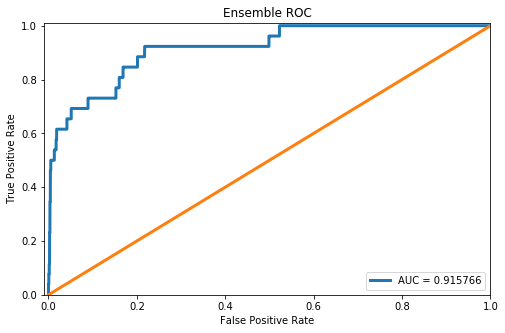

In [16]:
test_false_pos_rate = eclf_hard_eval[1]['false_pos_rate']
test_true_pos_rate = eclf_hard_eval[1]['true_pos_rate']
test_roc_auc = auc(test_false_pos_rate, test_true_pos_rate)

plt.figure(figsize=(8, 5))
plt.plot(test_false_pos_rate, test_true_pos_rate, linewidth=3, label='AUC = %f'% test_roc_auc)
plt.plot([0,1],[0,1], linewidth=3)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])

plt.legend(loc='lower right')
plt.title('Ensemble ROC')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Precision VS Recall

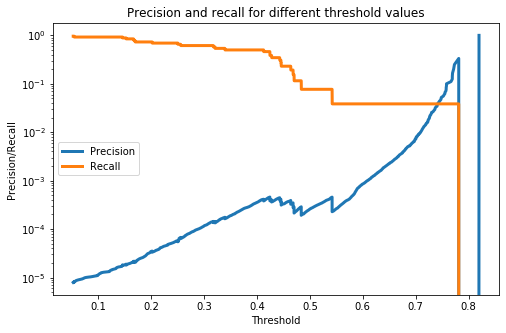

In [17]:
precision_rt = eclf_hard_eval[it]['precision_rt']
recall_rt = eclf_hard_eval[it]['recall_rt']
threshold_rate = eclf_hard_eval[it]['threshold_rt']

plt.figure(figsize=(8, 5))
plt.plot(threshold_rate, precision_rt[1:], label="Precision",linewidth=3)
plt.plot(threshold_rate, recall_rt[1:], label="Recall",linewidth=3)
plt.title('Precision and recall for different threshold values')
plt.yscale('log')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

# Confusion Matrix

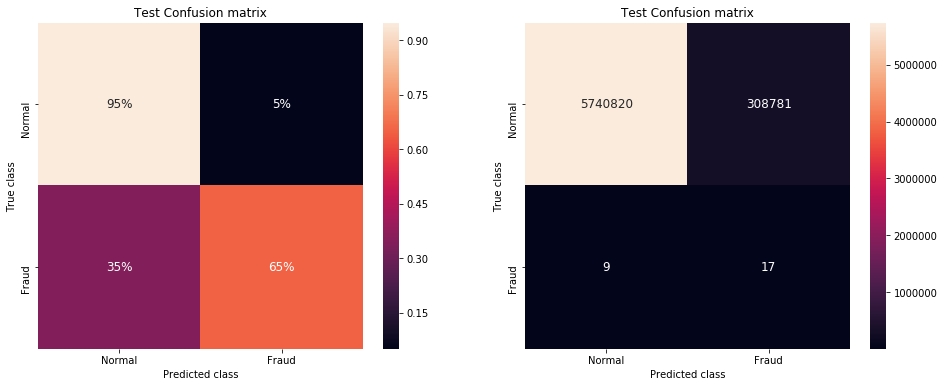

In [18]:
cnf_mtx_hard = confusion_matrix(original_ytest, eclf_hard_pred)
conf_matrix(cnf_mtx_hard)

# Individual Classifier Processing

In [19]:
iforest_pred = iforest.predict(original_Xtest)
iforest_score = iforest.decision_function(original_Xtest)
print('IForest Processed!')

IForest Processed!


In [20]:
hbos_pred = hbos.predict(original_Xtest)
hbos_score = hbos.decision_function(original_Xtest)
print('HBOS Processed!')

HBOS Processed!


In [21]:
cblof_pred = cblof.predict(original_Xtest)
cblof_score = cblof.decision_function(original_Xtest)
print('CBLOF Processed!')

CBLOF Processed!


In [22]:
pca_pred = pca.predict(original_Xtest)
pca_score = pca.decision_function(original_Xtest)
print('PCA Processed!')

PCA Processed!


In [23]:
autoencoder_pred = autoencoder.predict(original_Xtest)
autoencoder_score = autoencoder.decision_function(original_Xtest)
print('Autoencoder Processed!')

Autoencoder Processed!


In [24]:
kmeans_pred = kmeans.predict(original_Xtest)
#K-means don't have decision function as clusters don't offer probablities
print('Kmeans Processed!')

Kmeans Processed!


# Comparison

In [25]:
models_dict = {}

models_dict['IForest'] = evaluate(original_ytest, iforest_pred, iforest_score, 0)
models_dict['HBOS'] = evaluate(original_ytest, hbos_pred, hbos_score, 0)
models_dict['CBLOF'] = evaluate(original_ytest, cblof_pred, cblof_score, 0)
models_dict['PCA'] = evaluate(original_ytest, pca_pred, pca_score, 0)
models_dict['Kmeans'] = evaluate(original_ytest, kmeans_pred, [], 0)
models_dict['Autoencoder'] = evaluate(original_ytest, autoencoder_pred, autoencoder_score, 0)
models_dict['Ensemble'] = evaluate(original_ytest, eclf_hard_pred, eclf_hard_prob[:, 1], 0)

### Tabular

In [26]:
models_eval_df = pd.DataFrame(columns=['Classifer','Accuracy','Balanced-Accuracy','Macro-Precision','Macro-Recall','Macro-F1','Macro-ROC', 'Precision', 'Recall', 'F1', 'ROC', 'Time'])
for it in list(models_dict.keys()):
    models_eval_df = models_eval_df.append({'Classifer' : str(it),
                             'Accuracy' : models_dict[it]['accuracy'],
                             'Balanced-Accuracy' : models_dict[it]['balanced_accuracy'],
                             'Macro-Precision' : models_dict[it]['macro_precision'],
                             'Macro-Recall' : models_dict[it]['macro_recall'],
                             'Macro-F1' : models_dict[it]['macro_f1'],
                             'Macro-ROC' : models_dict[it]['macro_roc'],
                             'Precision' : models_dict[it]['precision'],
                             'Recall' : models_dict[it]['recall'],
                             'F1' : models_dict[it]['f1'],
                             'ROC' : models_dict[it]['roc'],
                             'Time' : models_dict[it]['time']                                              
                            }, ignore_index=True)
    
display(models_eval_df)

,Classifer,Accuracy,Balanced-Accuracy,Macro-Precision,Macro-Recall,Macro-F1,Macro-ROC,Precision,Recall,F1,ROC,Time
0,IForest,0.969937,0.792662,0.500043,0.792662,0.492457,0.905661,0.000088,0.615385,0.000176,0.905661,0
1,HBOS,0.871294,0.839493,0.500013,0.839493,0.465637,0.913317,0.000027,0.807692,0.000054,0.913317,0
2,CBLOF,0.848902,0.789836,0.500010,0.789836,0.459159,0.818955,0.000021,0.730769,0.000042,0.818955,0
3,PCA,0.881852,0.883234,0.500016,0.883234,0.468641,0.910491,0.000032,0.884615,0.000064,0.910491,0
4,Kmeans,0.865264,0.855709,0.500013,0.855709,0.463910,NA,0.000027,0.846154,0.000054,NA,0
5,Autoencoder,0.988407,0.744205,0.500092,0.744205,0.497270,0.884123,0.000185,0.500000,0.000371,0.884123,0
6,Ensemble,0.948957,0.801402,0.500027,0.801402,0.486960,0.915766,0.000055,0.653846,0.000110,0.915766,0


# Color Spectrum

In [27]:
colors_spectrum = {'IForest': '#009acd',
          'HBOS': '#00cdcd',
          'CBLOF': '#cd9a00',
          'PCA': '#9acd00',
          'Kmeans': '#0034cd',
          'Autoencoder': '#9900cd',
          'Ensemble': '#ff7a00'
         }

### ROC

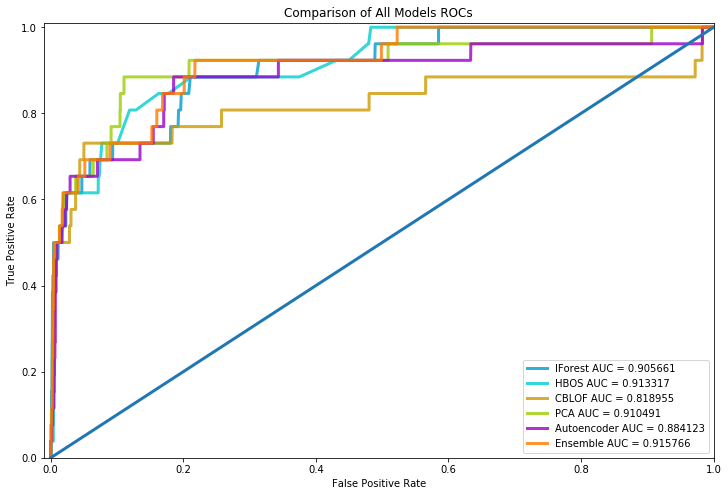

In [28]:
plt.figure(figsize=(12, 8))

for it in list(models_dict.keys()):
    if models_dict[it]['false_pos_rate'] != 'NA':
        test_false_pos_rate = models_dict[it]['false_pos_rate']
        test_true_pos_rate = models_dict[it]['true_pos_rate']
        test_roc_auc = auc(test_false_pos_rate, test_true_pos_rate)
        plt.plot(test_false_pos_rate, test_true_pos_rate, linewidth=3, label= str(it)+' AUC = %f'% test_roc_auc, alpha=0.8, c=colors_spectrum[it])

plt.plot([0,1],[0,1], linewidth=3)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])

plt.legend(loc='lower right')
plt.title('Comparison of All Models ROCs')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Precision 

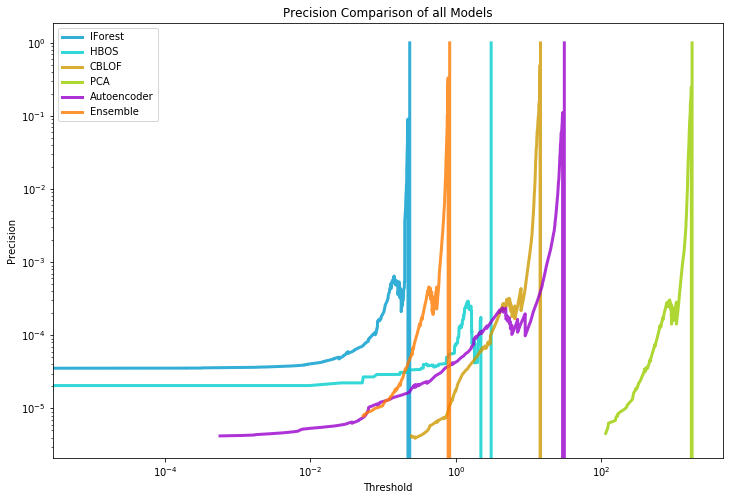

In [29]:
plt.figure(figsize=(12, 8))

for it in list(models_dict.keys()):
    if models_dict[it]['precision_rt'] != 'NA':
        precision_rt = models_dict[it]['precision_rt']
        threshold_rate = models_dict[it]['threshold_rt']
        plt.plot(threshold_rate, precision_rt[1:], label=str(it) ,linewidth=3, alpha=0.8, c=colors_spectrum[it])

plt.title('Precision Comparison of all Models')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.legend()
plt.show()

### Recall 

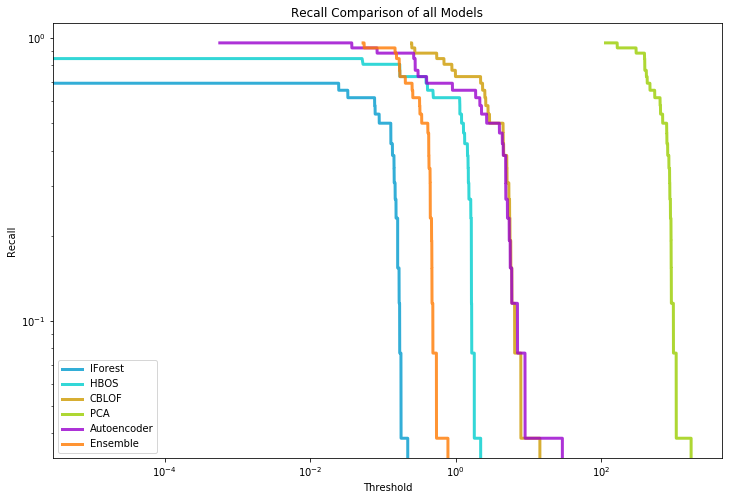

In [30]:
plt.figure(figsize=(12, 8))

for it in list(models_dict.keys()):
    if models_dict[it]['recall_rt'] != 'NA':
        recall_rt = models_dict[it]['recall_rt']
        threshold_rate = models_dict[it]['threshold_rt']
        plt.plot(threshold_rate, recall_rt[1:], label=str(it), linewidth=3, alpha=0.8, c=colors_spectrum[it])

plt.title('Recall Comparison of all Models')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.legend()
plt.show()

## Accuracy Comparison

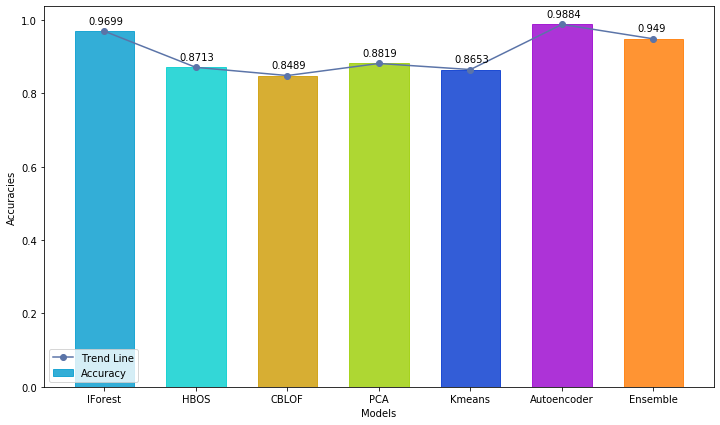

In [31]:
plt.figure(figsize=(12, 7))

X = models_eval_df['Classifer']
Y = models_eval_df['Accuracy']

rects1 = plt.bar(X, Y, 0.65,label='Accuracy', alpha=0.8)

high_point_x = []
high_point_y = []    
for i in range(0,len(X)):
    single_bar_group={rects1[i].get_height():rects1[i].get_x() + rects1[i].get_width()/2.0}
    rects1[i].set_color(colors_spectrum[X[i]])
    height_list = list(single_bar_group.keys())
    height_list.sort(reverse=True)
    for single_height in height_list:
        high_point_y.append(single_height)
        high_point_x.append(single_bar_group[single_height])
        break
        
for bar in rects1:
    yval = bar.get_height()
    plt.text(bar.get_x()+ 0.15, yval + .02, round(yval,4))

trend_line = plt.plot(high_point_x, high_point_y,marker='o', color='#5b74a8', label='Trend Line')

plt.xlabel('Models')
plt.ylabel('Accuracies')
plt.legend(loc='lower left')
plt.show()

## Balanced Accuracy Comparison 

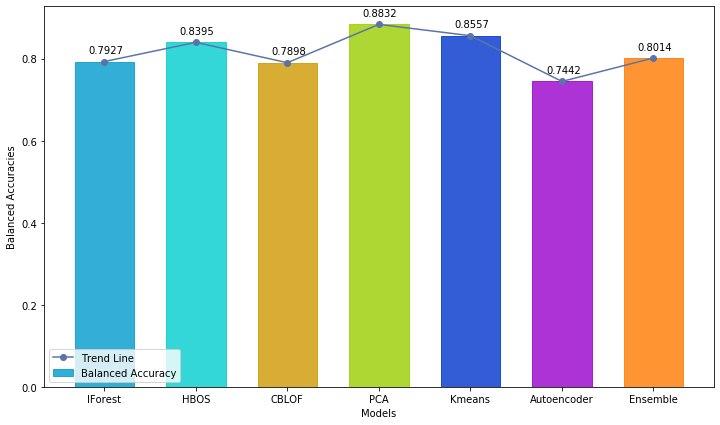

In [32]:
plt.figure(figsize=(12, 7))

X = models_eval_df['Classifer']
Y = models_eval_df['Balanced-Accuracy']

rects1 = plt.bar(X, Y, 0.65, label='Balanced Accuracy', alpha=0.8)

high_point_x = []
high_point_y = []    
for i in range(0,len(X)):
    single_bar_group={rects1[i].get_height():rects1[i].get_x() + rects1[i].get_width()/2.0}
    rects1[i].set_color(colors_spectrum[X[i]])
    height_list = list(single_bar_group.keys())
    height_list.sort(reverse=True)
    for single_height in height_list:
        high_point_y.append(single_height)
        high_point_x.append(single_bar_group[single_height])
        break
        
for bar in rects1:
    yval = bar.get_height()
    plt.text(bar.get_x()+ 0.15, yval + .02, round(yval,4))

trend_line = plt.plot(high_point_x, high_point_y,marker='o', color='#5b74a8', label='Trend Line')

plt.xlabel('Models')
plt.ylabel('Balanced Accuracies')
plt.legend(loc='lower left')
plt.show()

## Macro Precision

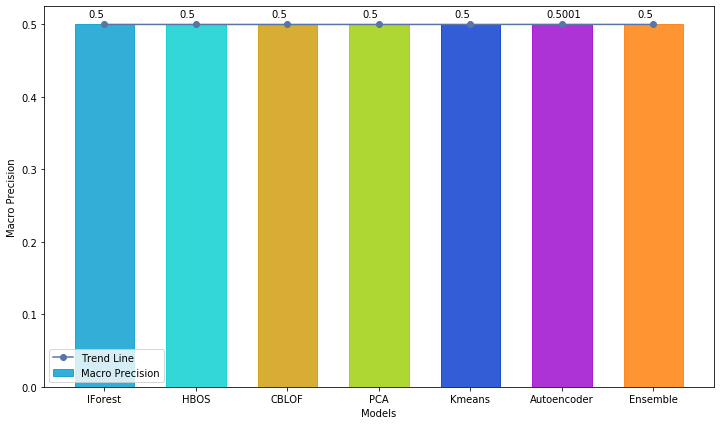

In [33]:
plt.figure(figsize=(12, 7))

X = models_eval_df['Classifer']
Y = models_eval_df['Macro-Precision']

rects1 = plt.bar(X, Y, 0.65,label='Macro Precision', alpha=0.8)

high_point_x = []
high_point_y = []    
for i in range(0,len(X)):
    single_bar_group={rects1[i].get_height():rects1[i].get_x() + rects1[i].get_width()/2.0}
    rects1[i].set_color(colors_spectrum[X[i]])
    height_list = list(single_bar_group.keys())
    height_list.sort(reverse=True)
    for single_height in height_list:
        high_point_y.append(single_height)
        high_point_x.append(single_bar_group[single_height])
        break
        
for bar in rects1:
    yval = bar.get_height()
    plt.text(bar.get_x()+ 0.15, yval + .01, round(yval,4))

trend_line = plt.plot(high_point_x, high_point_y,marker='o', color='#5b74a8', label='Trend Line')

plt.xlabel('Models')
plt.ylabel('Macro Precision')
plt.legend(loc='lower left')
plt.show()

## Macro Recall 

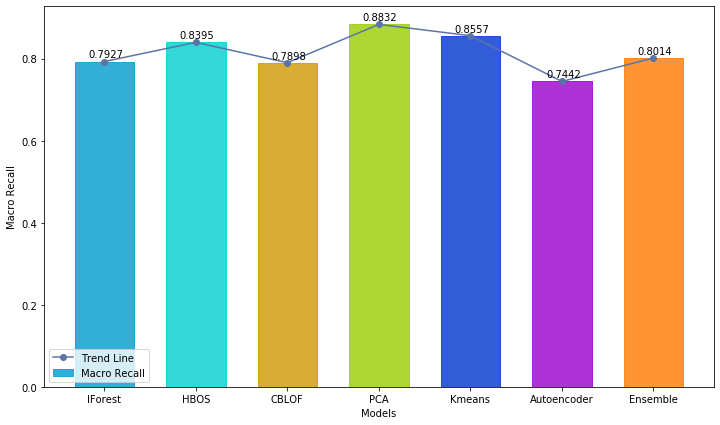

In [34]:
plt.figure(figsize=(12, 7))

X = models_eval_df['Classifer']
Y = models_eval_df['Macro-Recall']

rects1 = plt.bar(X, Y, 0.65,label='Macro Recall', alpha=0.8)

high_point_x = []
high_point_y = []    
for i in range(0,len(X)):
    single_bar_group={rects1[i].get_height():rects1[i].get_x() + rects1[i].get_width()/2.0}
    rects1[i].set_color(colors_spectrum[X[i]])
    height_list = list(single_bar_group.keys())
    height_list.sort(reverse=True)
    for single_height in height_list:
        high_point_y.append(single_height)
        high_point_x.append(single_bar_group[single_height])
        break
        
for bar in rects1:
    yval = bar.get_height()
    plt.text(bar.get_x()+ 0.15, yval + .01, round(yval,4))

trend_line = plt.plot(high_point_x, high_point_y,marker='o', color='#5b74a8', label='Trend Line')

plt.xlabel('Models')
plt.ylabel('Macro Recall')
plt.legend(loc='lower left')
plt.show()

## Macro F1

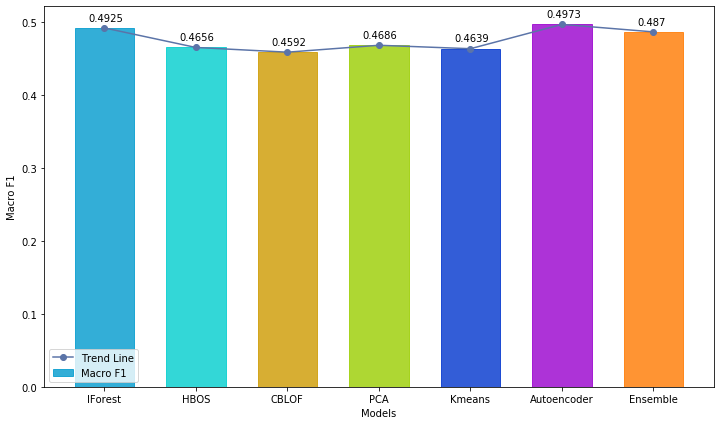

In [35]:
plt.figure(figsize=(12, 7))

X = models_eval_df['Classifer']
Y = models_eval_df['Macro-F1']

rects1 = plt.bar(X, Y, 0.65,label='Macro F1', alpha=0.8)

high_point_x = []
high_point_y = []    
for i in range(0,len(X)):
    single_bar_group={rects1[i].get_height():rects1[i].get_x() + rects1[i].get_width()/2.0}
    rects1[i].set_color(colors_spectrum[X[i]])
    height_list = list(single_bar_group.keys())
    height_list.sort(reverse=True)
    for single_height in height_list:
        high_point_y.append(single_height)
        high_point_x.append(single_bar_group[single_height])
        break
        
for bar in rects1:
    yval = bar.get_height()
    plt.text(bar.get_x()+ 0.15, yval + .01, round(yval,4))

trend_line = plt.plot(high_point_x, high_point_y,marker='o', color='#5b74a8', label='Trend Line')

plt.xlabel('Models')
plt.ylabel('Macro F1')
plt.legend(loc='lower left')
plt.show()